This notebook exists to mainly find out the best model used for prediction.

In [1]:
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import seaborn as sns
sns.set(font_scale=1.2)
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


SALE DATA

In [2]:
sale_df = pd.read_csv('../data/iProperty_sale_to_be_trained.csv')

sale_df.drop(['name','psf','area'], axis=1, inplace=True)

for col in ['price']:
    q_low = sale_df[col].quantile(0.01)
    q_hi  = sale_df[col].quantile(0.99)
    sale_df = sale_df[(sale_df[col] < q_hi) & (sale_df[col] > q_low)]
    
one_hot = pd.get_dummies(sale_df[['district','state','type','details']])
sale_df = sale_df.join(one_hot).drop(['district','state','type','details'], axis=1)

sale_x = sale_df.drop(['price'],axis=1)
sale_y = sale_df['price']

sale_x_train, sale_x_test, sale_y_train, sale_y_test = train_test_split(sale_x, sale_y, test_size=0.2)

In [3]:
rent_df = pd.read_csv('../data/iProperty_rent_to_be_trained.csv')

rent_df.drop(['name','psf','area'], axis=1, inplace=True)

for col in ['price']:
    q_low = rent_df[col].quantile(0.01)
    q_hi  = rent_df[col].quantile(0.99)
    rent_df = rent_df[(rent_df[col] < q_hi) & (rent_df[col] > q_low)]
    
one_hot = pd.get_dummies(rent_df[['district','state','type','details']])
rent_df = rent_df.join(one_hot).drop(['district','state','type','details'], axis=1)

rent_x = rent_df.drop(['price'],axis=1)
rent_y = rent_df['price']

rent_x_train, rent_x_test, rent_y_train, rent_y_test = train_test_split(rent_x, rent_y, test_size=0.2)

### Gradient Boosting Regressor

In [33]:
gb_hyperparameters = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_leaf': [2],
    'min_samples_split': [2],
    'loss': ['squared_error'],
    'ccp_alpha': [0.0],
    'min_weight_fraction_leaf': [0.0],
    'validation_fraction': [0.2,0.25,0.3],
}

In [30]:
gb_score = {
    'score':['R2','RMSE','MAE','MAPE']
}

on SALE DATA

In [31]:
gbs = GradientBoostingRegressor()
model_s = GridSearchCV(estimator=gbs, param_grid=gb_hyperparameters, cv=3, n_jobs=-1, verbose=4)
model_s.fit(sale_x_train, sale_y_train)
pd.DataFrame.from_dict(model_s.cv_results_).sort_values(['mean_test_score','std_test_score'],ascending=False).T

Fitting 3 folds for each of 3 candidates, totalling 9 fits


,1,2,0
mean_fit_time,14.970442,12.367586,14.894081
std_fit_time,0.11566,3.633249,0.183254
mean_score_time,0.078103,0.074842,0.079647
std_score_time,0.045864,0.046915,0.034441
param_ccp_alpha,0.0,0.0,0.0
param_loss,squared_error,squared_error,squared_error
param_max_depth,10,10,10
param_min_samples_leaf,2,2,2
param_min_samples_split,2,2,2
param_min_weight_fraction_leaf,0.0,0.0,0.0


In [34]:
gbs_best_params = model_s.best_params_
gbs_best_params

{'ccp_alpha': 0.0,
 'loss': 'squared_error',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'validation_fraction': 0.25}

In [36]:
key = 'SALE'

gbs = GradientBoostingRegressor()
gbs.set_params(**gbs_best_params)
gbs.fit(sale_x_train,sale_y_train)
sale_y_pred = gbs.predict(sale_x_test)

gb_score[key] = []
gb_score[key].append(r2_score(sale_y_test,sale_y_pred))
gb_score[key].append(mean_squared_error(sale_y_test,sale_y_pred, squared=False))
gb_score[key].append(mean_absolute_error(sale_y_test,sale_y_pred))
gb_score[key].append(mean_absolute_percentage_error(sale_y_test,sale_y_pred))

gb_score

{'score': ['R2', 'RMSE', 'MAE', 'MAPE'],
 'SALE': [0.7927363403016993,
  455289.19407320605,
  248615.838846038,
  0.2625406043618125]}

on RENT DATA

In [39]:
gbr = GradientBoostingRegressor()
model_r = GridSearchCV(estimator=gb, param_grid=gb_hyperparameters, cv=3, n_jobs=-1, verbose=4)
model_r.fit(rent_x_train, rent_y_train)
pd.DataFrame.from_dict(model.cv_results_).sort_values(['mean_test_score','std_test_score'],ascending=False).T

Fitting 3 folds for each of 3 candidates, totalling 9 fits


,0,1,2
mean_fit_time,9.293679,9.232416,7.39551
std_fit_time,0.076251,0.12637,2.560804
mean_score_time,0.033402,0.063373,0.037055
std_score_time,0.002854,0.023481,0.029982
param_ccp_alpha,0.0,0.0,0.0
param_loss,squared_error,squared_error,squared_error
param_max_depth,10,10,10
param_min_samples_leaf,2,2,2
param_min_samples_split,2,2,2
param_min_weight_fraction_leaf,0.0,0.0,0.0


In [41]:
gbr_best_params = model.best_params_

gbr_best_params

{'ccp_alpha': 0.0,
 'loss': 'squared_error',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'validation_fraction': 0.2}

In [44]:
key = 'RENT'

gbr = GradientBoostingRegressor()
gbr.set_params(**gbr_best_params)
gbr.fit(rent_x_train,rent_y_train)
rent_y_pred = gbr.predict(rent_x_test)

gb_score[key] = []
gb_score[key].append(r2_score(rent_y_test,rent_y_pred))
gb_score[key].append(mean_squared_error(rent_y_test,rent_y_pred, squared=False))
gb_score[key].append(mean_absolute_error(rent_y_test,rent_y_pred))
gb_score[key].append(mean_absolute_percentage_error(rent_y_test,rent_y_pred))

gb_score

{'score': ['R2', 'RMSE', 'MAE', 'MAPE'],
 'SALE': [0.7927363403016993,
  455289.19407320605,
  248615.838846038,
  0.2625406043618125],
 'RENT': [0.7622806209311808,
  943.3773980929838,
  572.169634070497,
  0.24565731086907477]}

Display

In [45]:
gb_df = pd.DataFrame(gb_score).T
gb_df.columns = gb_df.iloc[0]
gb_df = gb_df[1:]
gb_df = gb_df.reset_index()
gb_df.rename(columns={'index':'data'}, inplace=True)
gb_df

score,data,R2,RMSE,MAE,MAPE
0,SALE,0.792736,455289.194073,248615.838846,0.262541
1,RENT,0.762281,943.377398,572.169634,0.245657


(array([0, 1]), [Text(0, 0, 'SALE'), Text(1, 0, 'RENT')])

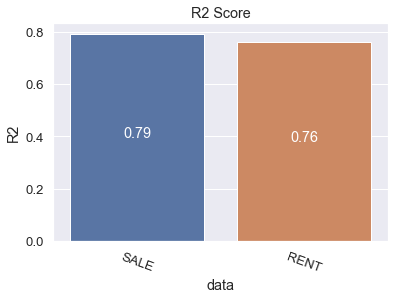

In [46]:
p = sns.barplot(data=gb_df, x='data', y='R2')
p.set_title('R2 Score')
for i in range(len(gb_df)):
    p.text(i,gb_df.R2[i]/2,str(round(gb_df.R2[i],2)),
           fontdict=dict(color='white'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1]), [Text(0, 0, 'SALE'), Text(1, 0, 'RENT')])

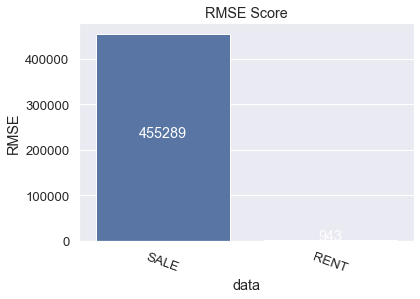

In [47]:
p = sns.barplot(data=gb_df, x='data', y='RMSE')
p.set_title('RMSE Score')
for i in range(len(gb_df)):
    p.text(i,gb_df.RMSE[i]/2,str(round(gb_df.RMSE[i])),
           fontdict=dict(color='white'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1]), [Text(0, 0, 'SALE'), Text(1, 0, 'RENT')])

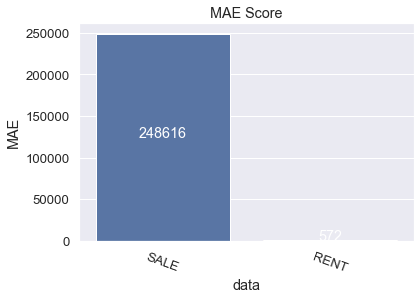

In [49]:
p = sns.barplot(data=gb_df, x='data', y='MAE')
p.set_title('MAE Score')
for i in range(len(gb_df)):
    p.text(i,gb_df.MAE[i]/2,str(round(gb_df.MAE[i])),
           fontdict=dict(color='white'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1]), [Text(0, 0, 'SALE'), Text(1, 0, 'RENT')])

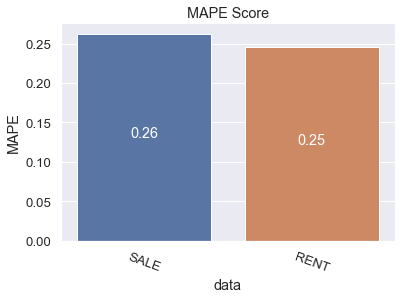

In [50]:
p = sns.barplot(data=gb_df, x='data', y='MAPE')
p.set_title('MAPE Score')
for i in range(len(gb_df)):
    p.text(i,gb_df.MAPE[i]/2,str(round(gb_df.MAPE[i],2)),
           fontdict=dict(color='white'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

### XGB Regressor

In [54]:
xg_hyperparameters = {
    'n_estimators': [100,200,300],
    'max_depth': [3,5,10],
    'eta': [0.1,0.2,0.05]
}

In [55]:
xg_score = {
    'score':['R2','RMSE','MAE','MAPE']
}

on SALE DATA

In [56]:
xgs = XGBRegressor()
model_s = GridSearchCV(estimator=xgs, param_grid=xg_hyperparameters, cv=3, n_jobs=-1, verbose=4)
model_s.fit(sale_x_train, sale_y_train)

xgs_best_params = model_s.best_params_
display(xgs_best_params)

pd.DataFrame.from_dict(model_s.cv_results_).sort_values(['mean_test_score','std_test_score'],ascending=False).T

Fitting 3 folds for each of 27 candidates, totalling 81 fits


,14,13,5,11,8,26,7,12,4,25,...,2,3,22,9,1,20,21,0,19,18
mean_fit_time,49.932015,33.879422,43.907941,31.951307,92.08158,62.788925,60.277363,16.722402,27.27241,54.861497,...,22.322437,11.536215,32.742558,10.737137,14.505162,31.314971,16.379072,7.533181,21.011268,10.661516
std_fit_time,0.145913,0.115859,0.608982,0.232867,0.377137,1.236442,0.895558,0.072754,0.744712,1.934985,...,0.918825,0.491343,0.101052,0.129509,0.062825,0.08763,0.063688,0.03294,0.072451,0.040098
mean_score_time,0.221408,0.203974,0.216933,0.201436,0.328817,0.141894,0.253855,0.206403,0.189663,0.201445,...,0.15439,0.166945,0.197228,0.182051,0.14607,0.203067,0.192343,0.130073,0.200113,0.184343
std_score_time,0.001991,0.005773,0.00786,0.007742,0.019675,0.025765,0.001554,0.028467,0.001728,0.009033,...,0.01629,0.015191,0.003867,0.005045,0.001935,0.004096,0.001647,0.001659,0.00746,0.008036
param_eta,0.2,0.2,0.1,0.2,0.1,0.05,0.1,0.2,0.1,0.05,...,0.1,0.1,0.05,0.2,0.1,0.05,0.05,0.1,0.05,0.05
param_max_depth,5,5,5,3,10,10,10,5,5,10,...,3,5,5,3,3,3,5,3,3,3
param_n_estimators,300,200,300,300,300,300,200,100,200,200,...,300,100,200,100,200,300,100,100,200,100
params,"{'eta': 0.2, 'max_depth': 5, 'n_estimators': 300}","{'eta': 0.2, 'max_depth': 5, 'n_estimators': 200}","{'eta': 0.1, 'max_depth': 5, 'n_estimators': 300}","{'eta': 0.2, 'max_depth': 3, 'n_estimators': 300}","{'eta': 0.1, 'max_depth': 10, 'n_estimators': ...","{'eta': 0.05, 'max_depth': 10, 'n_estimators':...","{'eta': 0.1, 'max_depth': 10, 'n_estimators': ...","{'eta': 0.2, 'max_depth': 5, 'n_estimators': 100}","{'eta': 0.1, 'max_depth': 5, 'n_estimators': 200}","{'eta': 0.05, 'max_depth': 10, 'n_estimators':...",...,"{'eta': 0.1, 'max_depth': 3, 'n_estimators': 300}","{'eta': 0.1, 'max_depth': 5, 'n_estimators': 100}","{'eta': 0.05, 'max_depth': 5, 'n_estimators': ...","{'eta': 0.2, 'max_depth': 3, 'n_estimators': 100}","{'eta': 0.1, 'max_depth': 3, 'n_estimators': 200}","{'eta': 0.05, 'max_depth': 3, 'n_estimators': ...","{'eta': 0.05, 'max_depth': 5, 'n_estimators': ...","{'eta': 0.1, 'max_depth': 3, 'n_estimators': 100}","{'eta': 0.05, 'max_depth': 3, 'n_estimators': ...","{'eta': 0.05, 'max_depth': 3, 'n_estimators': ..."
split0_test_score,0.779544,0.77658,0.77015,0.772671,0.76565,0.76276,0.76458,0.767481,0.763291,0.760915,...,0.756502,0.7499,0.74919,0.748816,0.744745,0.735822,0.729663,0.721596,0.720199,0.688216
split1_test_score,0.796259,0.796091,0.790957,0.786393,0.794618,0.797169,0.794951,0.787065,0.786138,0.795379,...,0.772321,0.772793,0.774483,0.765711,0.760577,0.753,0.750099,0.738538,0.737911,0.696196


{'eta': 0.2, 'max_depth': 5, 'n_estimators': 300}

In [59]:
key = 'SALE'

xgs = XGBRegressor()
xgs.set_params(**xgs_best_params)
xgs.fit(sale_x_train,sale_y_train)
sale_y_pred = xgs.predict(sale_x_test)

xg_score[key] = []
xg_score[key].append(r2_score(sale_y_test,sale_y_pred))
xg_score[key].append(mean_squared_error(sale_y_test,sale_y_pred, squared=False))
xg_score[key].append(mean_absolute_error(sale_y_test,sale_y_pred))
xg_score[key].append(mean_absolute_percentage_error(sale_y_test,sale_y_pred))

xg_score

{'score': ['R2', 'RMSE', 'MAE', 'MAPE'],
 'SALE': [0.7985584656983852,
  448849.01034117193,
  250306.0723387447,
  0.2637002150213529]}

on RENT DATA

In [62]:
xgr = XGBRegressor()
model_r = GridSearchCV(estimator=xgr, param_grid=xg_hyperparameters, cv=3, n_jobs=-1, verbose=4)
model_r.fit(sale_x_train, sale_y_train)

xgr_best_params = model_r.best_params_
display(xgr_best_params)

pd.DataFrame.from_dict(model_r.cv_results_).sort_values(['mean_test_score','std_test_score'],ascending=False).T

Fitting 3 folds for each of 27 candidates, totalling 81 fits


,14,13,5,11,8,26,7,12,4,25,...,2,3,22,9,1,20,21,0,19,18
mean_fit_time,47.710935,32.194564,47.908771,31.218703,90.969596,69.187745,61.285926,16.3242,32.200638,60.034881,...,31.052509,16.402615,32.656539,10.97811,21.015585,32.531038,17.302255,10.640938,20.894014,10.680444
std_fit_time,0.110872,0.122869,0.225129,0.028666,0.121949,2.199385,0.192087,0.069893,0.237422,2.126543,...,0.085787,0.117301,0.183438,0.285585,0.133597,0.314443,0.524872,0.055693,0.015406,0.03382
mean_score_time,0.213303,0.198899,0.215139,0.213761,0.282775,0.150101,0.23755,0.185203,0.194641,0.205901,...,0.207505,0.190878,0.207264,0.190154,0.196348,0.199237,0.202562,0.195158,0.188616,0.174008
std_score_time,0.006916,0.00608,0.008284,0.018814,0.010317,0.034488,0.008121,0.007039,0.002241,0.013569,...,0.010688,0.001067,0.013353,0.009723,0.006826,0.004475,0.007006,0.011988,0.005345,0.002401
param_eta,0.2,0.2,0.1,0.2,0.1,0.05,0.1,0.2,0.1,0.05,...,0.1,0.1,0.05,0.2,0.1,0.05,0.05,0.1,0.05,0.05
param_max_depth,5,5,5,3,10,10,10,5,5,10,...,3,5,5,3,3,3,5,3,3,3
param_n_estimators,300,200,300,300,300,300,200,100,200,200,...,300,100,200,100,200,300,100,100,200,100
params,"{'eta': 0.2, 'max_depth': 5, 'n_estimators': 300}","{'eta': 0.2, 'max_depth': 5, 'n_estimators': 200}","{'eta': 0.1, 'max_depth': 5, 'n_estimators': 300}","{'eta': 0.2, 'max_depth': 3, 'n_estimators': 300}","{'eta': 0.1, 'max_depth': 10, 'n_estimators': ...","{'eta': 0.05, 'max_depth': 10, 'n_estimators':...","{'eta': 0.1, 'max_depth': 10, 'n_estimators': ...","{'eta': 0.2, 'max_depth': 5, 'n_estimators': 100}","{'eta': 0.1, 'max_depth': 5, 'n_estimators': 200}","{'eta': 0.05, 'max_depth': 10, 'n_estimators':...",...,"{'eta': 0.1, 'max_depth': 3, 'n_estimators': 300}","{'eta': 0.1, 'max_depth': 5, 'n_estimators': 100}","{'eta': 0.05, 'max_depth': 5, 'n_estimators': ...","{'eta': 0.2, 'max_depth': 3, 'n_estimators': 100}","{'eta': 0.1, 'max_depth': 3, 'n_estimators': 200}","{'eta': 0.05, 'max_depth': 3, 'n_estimators': ...","{'eta': 0.05, 'max_depth': 5, 'n_estimators': ...","{'eta': 0.1, 'max_depth': 3, 'n_estimators': 100}","{'eta': 0.05, 'max_depth': 3, 'n_estimators': ...","{'eta': 0.05, 'max_depth': 3, 'n_estimators': ..."
split0_test_score,0.779544,0.77658,0.77015,0.772671,0.76565,0.76276,0.76458,0.767481,0.763291,0.760915,...,0.756502,0.7499,0.74919,0.748816,0.744745,0.735822,0.729663,0.721596,0.720199,0.688216
split1_test_score,0.796259,0.796091,0.790957,0.786393,0.794618,0.797169,0.794951,0.787065,0.786138,0.795379,...,0.772321,0.772793,0.774483,0.765711,0.760577,0.753,0.750099,0.738538,0.737911,0.696196


{'eta': 0.2, 'max_depth': 5, 'n_estimators': 300}

In [64]:
key = 'RENT'

xgr = XGBRegressor()
xgr.set_params(**xgr_best_params)
xgr.fit(rent_x_train,rent_y_train)
rent_y_pred = xgr.predict(rent_x_test)

xg_score[key] = []
xg_score[key].append(r2_score(rent_y_test,rent_y_pred))
xg_score[key].append(mean_squared_error(rent_y_test,rent_y_pred, squared=False))
xg_score[key].append(mean_absolute_error(rent_y_test,rent_y_pred))
xg_score[key].append(mean_absolute_percentage_error(rent_y_test,rent_y_pred))

xg_score

{'score': ['R2', 'RMSE', 'MAE', 'MAPE'],
 'SALE': [0.7985584656983852,
  448849.01034117193,
  250306.0723387447,
  0.2637002150213529],
 'RENT': [0.7806964329708708,
  906.0997721910044,
  563.9534937287463,
  0.24271897486400673]}

In [65]:
xg_df = pd.DataFrame(xg_score).T
xg_df.columns = xg_df.iloc[0]
xg_df = xg_df[1:]
xg_df = xg_df.reset_index()
xg_df.rename(columns={'index':'data'}, inplace=True)
xg_df

score,data,R2,RMSE,MAE,MAPE
0,SALE,0.798558,448849.010341,250306.072339,0.2637
1,RENT,0.780696,906.099772,563.953494,0.242719


(array([0, 1]), [Text(0, 0, 'SALE'), Text(1, 0, 'RENT')])

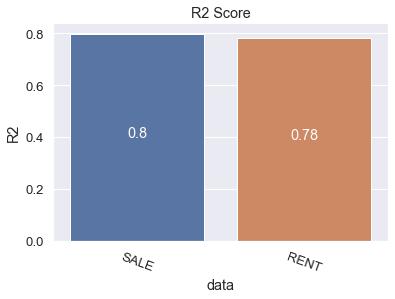

In [73]:
metric = 'R2'
p = sns.barplot(data=xg_df, x='data', y='R2')
p.set_title('{} Score'.format(metric))
for i in range(len(xg_df)):
    p.text(i,xg_df[metric][i]/2,str(round(xg_df[metric][i],2)),
           fontdict=dict(color='white'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1]), [Text(0, 0, 'SALE'), Text(1, 0, 'RENT')])

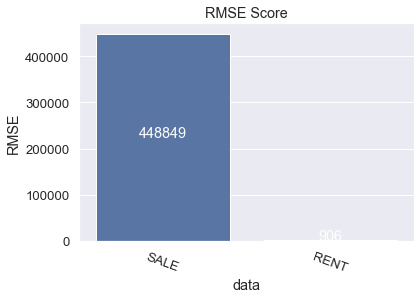

In [75]:
metric = 'RMSE'
p = sns.barplot(data=xg_df, x='data', y=metric)
p.set_title('{} Score'.format(metric))
for i in range(len(xg_df)):
    p.text(i,xg_df[metric][i]/2,str(round(xg_df[metric][i])),
           fontdict=dict(color='white'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1]), [Text(0, 0, 'SALE'), Text(1, 0, 'RENT')])

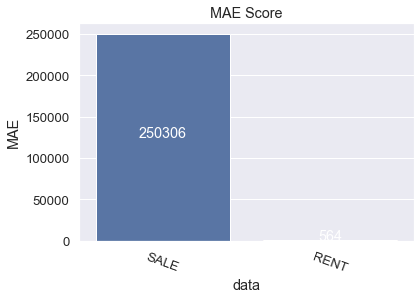

In [81]:
metric = 'MAE'
p = sns.barplot(data=xg_df, x='data', y=metric)
p.set_title('{} Score'.format(metric))
for i in range(len(xg_df)):
    p.text(i,xg_df[metric][i]/2,str(round(xg_df[metric][i])),
           fontdict=dict(color='white'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

(array([0, 1]), [Text(0, 0, 'SALE'), Text(1, 0, 'RENT')])

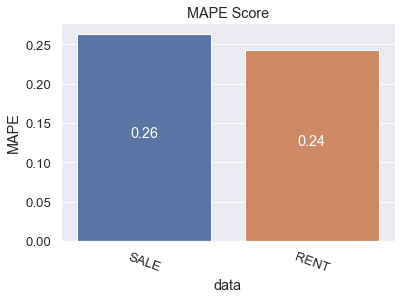

In [78]:
metric = 'MAPE'
p = sns.barplot(data=xg_df, x='data', y=metric)
p.set_title('{} Score'.format(metric))
for i in range(len(xg_df)):
    p.text(i,xg_df[metric][i]/2,str(round(xg_df[metric][i],2)),
           fontdict=dict(color='white'),
          horizontalalignment='center')
plt.xticks(rotation=-20)

### Random Forest Regressor

In [82]:
rf_hyperparameters = {
    'n_estimators': [100,200,300],
    'max_depth': [3,5,10],
}

In [83]:
rf_score = {
    'score':['R2','RMSE','MAE','MAPE']
}

In [ ]:
rfs = RandomForestRegressor()
model_s = GridSearchCV(estimator=rfs, param_grid=rf_hyperparameters, cv=3, n_jobs=-1, verbose=4)
model_s.fit(sale_x_train, sale_y_train)

rfs_best_params = model_s.best_params_
display(xgs_best_params)

pd.DataFrame.from_dict(model_s.cv_results_).sort_values(['mean_test_score','std_test_score'],ascending=False).T

In [ ]:
key = 'SALE'

rfs = RandomForestRegressor()
rfs.set_params(**rfs_best_params)
rfs.fit(sale_x_train,sale_y_train)
sale_y_pred = rfs.predict(sale_x_test)

rf_score[key] = []
rf_score[key].append(r2_score(sale_y_test,sale_y_pred))
rf_score[key].append(mean_squared_error(sale_y_test,sale_y_pred, squared=False))
rf_score[key].append(mean_absolute_error(sale_y_test,sale_y_pred))
rf_score[key].append(mean_absolute_percentage_error(sale_y_test,sale_y_pred))

rf_score